#### NX-414: Brain-like computation and intelligence
##### TA: Alessandro Marin Vargas

# Week 6 - Mini project (Predicting neural activity)

The objectives of the mini project are:
- Learn how to predict neural activity using linear regression from images and from neural network layers.
- Quantify the goodness of the model
- Compare the results across the network layers and between trained/random neural network
- Predict the neural activity using a neural network in a data-driven approach

Specifically, here you will use the data from the following [paper](https://www.jneurosci.org/content/jneuro/35/39/13402.full.pdf). The behavioral experiment consisted in showing to non-human primates some images while recording the neural activity with multielectrode arrays from the inferior temporal (IT) cortex. In the data we provided you, the neural activity and the images are already pre-processed and you will have available the images and the corresponding average firing rate (between 70 and 170 ms) per each neuron.

### Deadline for Mini-Project Submission: May 7, 2024

You are required to submit your mini-projects by midnight on 07/05/24. Please upload a .zip file to Moodle containing your code, along with the following specific components:

- One-Page Report (Report.pdf): This should detail your investigative process and include:
    - A comparison table of models. This should cover linear regression from stimuli, both trained and random task-driven models, data-driven models, and your best-performing model.
    - A figure illustrating the variation in neural prediction across different layers of a task-driven model.
    - Your exploration to develop the most effective model at predicting IT neural activity
- Example Script/Notebook: Please provide a script (test.py) or a notebook (test.ipynb) demonstrating how your best model performs on the validation set. This should serve as an example of the model's usage.

<!-- You have until midnight of 07/05/23 to submit your mini-projects. You will be requested to upload a .zip file on Moodle containing your code and, specifically, the following:

- A one-page report (Report.pdf) detailing your investigation:
    - A table with model comparison: linear regression from stimuli, task-driven models (trained and random), data-driven models and your best model
    - A figure showing how the neural prediction changes across layer of a task-driven model
- A script (test.py) or notebook (test.ipynb) in which you show an example of your best model's usage on the validation set. -->

In [1]:
import sys

!{sys.executable} -m pip install gdown h5py

In [2]:
from utils import load_it_data, visualize_img
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import gdown

url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
output = "IT_data.h5"
gdown.download(url, output, quiet=False, fuzzy=True)

Downloading...
From (original): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS
From (redirected): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS&confirm=t&uuid=bbe9736f-4c19-498e-8a77-372e6bacc967
To: /home/celia/NX-414/IT_data.h5
100%|██████████| 384M/384M [00:12<00:00, 31.9MB/s] 


'IT_data.h5'

### Load the data

In [3]:
path_to_data = ""  ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

(
    stimulus_train,
    stimulus_val,
    stimulus_test,
    objects_train,
    objects_val,
    objects_test,
    spikes_train,
    spikes_val,
) = load_it_data(path_to_data)

In [4]:
n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape
print(
    "The train dataset contains {} stimuli and {} IT neurons".format(
        n_stimulus, n_neurons
    )
)
print("Each stimulus have {} channgels (RGB)".format(n_channels))
print("The size of the image is {}x{}".format(img_size, img_size))

The train dataset contains 2592 stimuli and 168 IT neurons
Each stimulus have 3 channgels (RGB)
The size of the image is 224x224


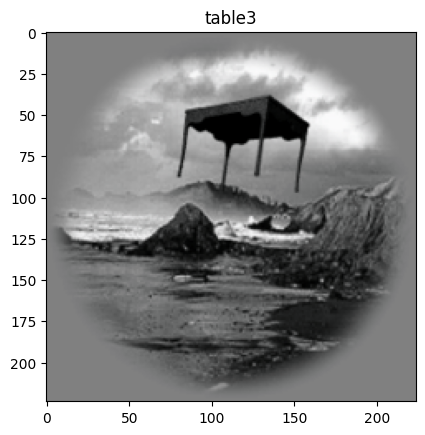

In [5]:
stim_idx = 1

visualize_img(stimulus_train, objects_train, stim_idx)

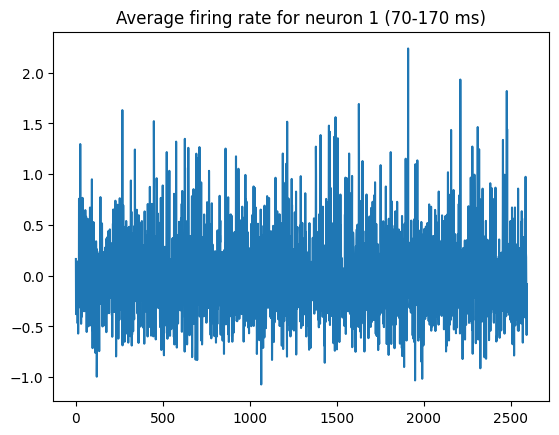

In [6]:
neuron_idx = 1

plt.figure()
plt.title("Average firing rate for neuron {} (70-170 ms)".format(neuron_idx))
plt.plot(spikes_train[:, neuron_idx])

## Part 1: Predict the neural activity from pixels

##### Develop a linear regression model that predict the neural activity from pixels.
You can try out different types of linear regression (ridge, least-square regression)

In [7]:
import sklearn.metrics
import sklearn.linear_model

In [8]:
# flatten the RGB channels (n_images, 3, 224, 224) --> (n_images, -1)
stimulus_train_flatten = stimulus_train.reshape(stimulus_train.shape[0], -1)
stimulus_val_flatten = stimulus_val.reshape(stimulus_val.shape[0], -1)

### Linear regression

In [9]:
reg = sklearn.linear_model.LinearRegression()
reg.fit(stimulus_train_flatten, spikes_train)

score_train = reg.score(stimulus_train_flatten, spikes_train)
score_val = reg.score(stimulus_val_flatten, spikes_val)

reg_pred_val = reg.predict(stimulus_val_flatten)
mse_reg = sklearn.metrics.mean_squared_error(spikes_val, reg_pred_val)
explained_variance_val = sklearn.metrics.explained_variance_score(
    spikes_val, reg_pred_val, multioutput="raw_values"
)

print(
    f"score_train: {score_train}, score_val: {score_val}\n"
    f"val_mse: {mse_reg}, val_variance_explained: {np.mean(explained_variance_val)}"
)

score_train: 0.9999999655324388, score_val: -1.1712276863409254
val_mse: 0.28567051887512207, val_variance_explained: -1.161533841774577


### Ridge regression

In [10]:
ridge = sklearn.linear_model.Ridge(alpha=1.0)
ridge.fit(stimulus_train_flatten, spikes_train)

score_train = ridge.score(stimulus_train_flatten, spikes_train)
score_val = ridge.score(stimulus_val_flatten, spikes_val)

ridge_pred_val = ridge.predict(stimulus_val_flatten)
mse_ridge = sklearn.metrics.mean_squared_error(spikes_val, ridge_pred_val)
explained_variance_val = sklearn.metrics.explained_variance_score(
    spikes_val, ridge_pred_val, multioutput="raw_values"
)

print(
    f"score_train: {score_train}, score_val: {score_val}\n"
    f"val_mse: {mse_ridge}, val_variance_explained: {np.mean(explained_variance_val)}"
)

/home/celia/miniconda3/envs/neuro/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:241: LinAlgWarning: Ill-conditioned matrix (rcond=4.7811e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


score_train: 0.9999987841343382, score_val: -1.1670413625088987
val_mse: 0.2851777672767639, val_variance_explained: -1.1573757962101983


**Interpretation:** For both the linear regression and ridge regression, the model overfits on the training data.

##### Evaluate your prediction (Check both the correlation and explained variance for each neuron). Plot the distribution for the explained variance across neurons.

In [11]:
# Compute the predictions for training and validation data from the ridge regression model
pred_train = ridge.predict(stimulus_train_flatten)
pred_val = ridge.predict(stimulus_val_flatten)

**1. Explained variance**

In [12]:
explained_variance_train = sklearn.metrics.explained_variance_score(
    spikes_train, pred_train, multioutput="raw_values"
)
explained_variance_val = sklearn.metrics.explained_variance_score(
    spikes_val, pred_val, multioutput="raw_values"
)

In [13]:
print(
    f"Mean train explained variance: {round(explained_variance_train.mean(), 2)}; "
    f"Standard deviation: {round(explained_variance_train.std(), 4)}\n"
    f"Mean valid explained variance: {round(explained_variance_val.mean(), 2)}; "
    f"Standard deviation: {round(explained_variance_val.std(), 4)}"
)

Mean train explained variance: 1.0; Standard deviation: 0.0
Mean valid explained variance: -1.16; Standard deviation: 0.3924


Text(0.5, 1.0, 'Validation set')

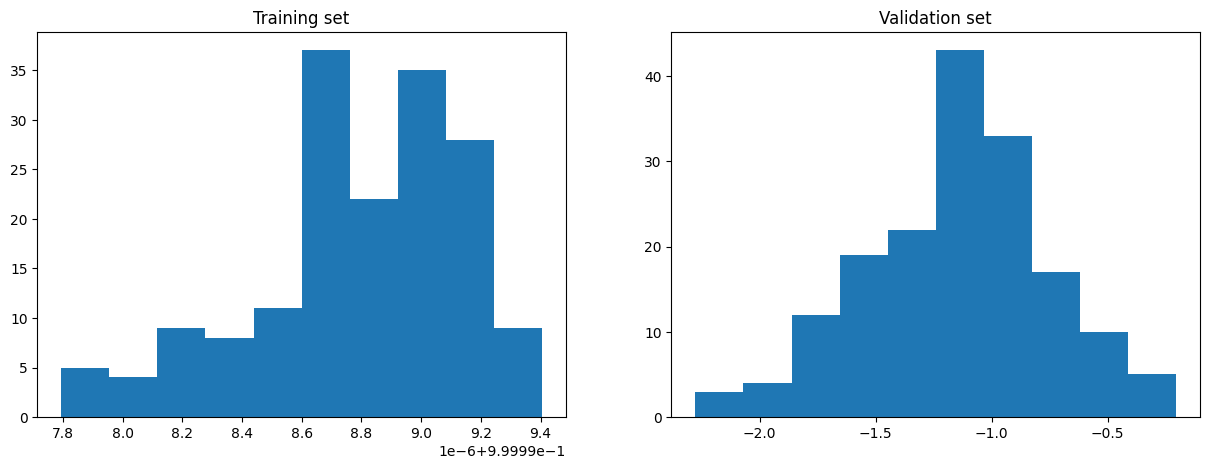

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(explained_variance_train)
axes[0].set_title("Training set")
axes[1].hist(explained_variance_val)
axes[1].set_title("Validation set")

**Interpretation of the explained variance:**

Explained variance is computed using

$ Explained\_Variance = 1− \frac{Variance\_original\_values}{Variance\_errors} $

The distribution of the explained variance score across neurons for the training data is narrow, centered on 1 (higher score) while validation explained variance score is negative, indicating that the model predicts worth than a simple model that would just predict the mean of the target distribution. This confirms that the mode overfitted on the training data and consequently perform poorly on unseen data.


**2. Correlation between neurons**

In [15]:
corr_matrix_train = np.corrcoef(spikes_train, pred_train, rowvar=False)
corr_matrix_val = np.corrcoef(spikes_val, pred_val, rowvar=False)

Text(0.5, 1.0, 'Validation set')

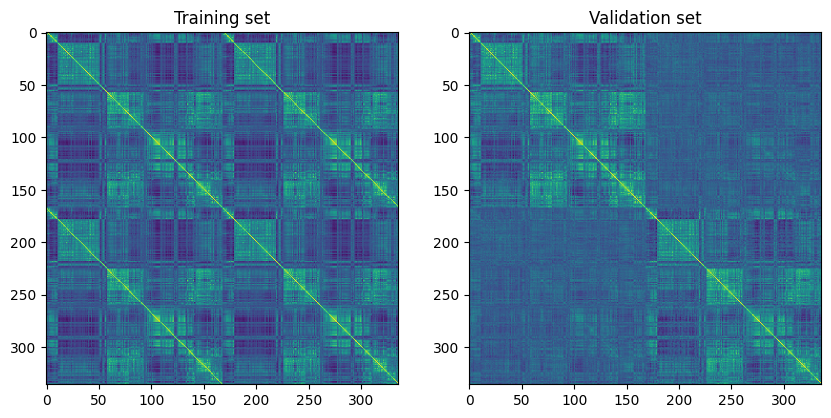

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

axes[0].imshow(corr_matrix_train)
axes[0].set_title("Training set")
axes[1].imshow(corr_matrix_val)
axes[1].set_title("Validation set")

**Interpretation of the correlation matrix:** 

`np.corrcoef` computes the correlation coefficients for every possible pair of columns across both matrices.

- *Top-Left Quarter:* Correlation among the neuron trace.
- *Bottom-Right Quarter:* Correlation among the predicted neuron trace.
- *Top-Right Quarter:* Correlation between each neuron trace and each predicted neuron trace.
- *Bottom-Left Quarter:* Correlation between each neuron trace and each predicted neuron trace. Transpose of the top-right quarter.

For both training and validation data, the autocorrelation (quarters on the diagonals) are similar. However, the neuron trace and predicted neuron trace in the validation data show little to no correlation, once again showing that data overfitted on the training data.

##### Predicting from pixels is very hard and the model is likely to overfit. An image is very high-dimensional, try to retain the corresponding 1000 PCs and use them to predict the neural activity. 

In [17]:
from sklearn.decomposition import PCA

In [18]:
# Compute the 1000 PCs
pca = PCA(n_components=1000)
stimulus_train_pcs = pca.fit_transform(stimulus_train_flatten)
stimulus_val_pcs = pca.transform(stimulus_val_flatten)

**Linear regression with 1000 first PCs**

In [23]:
reg_pcs = sklearn.linear_model.LinearRegression()
reg_pcs.fit(stimulus_train_pcs, spikes_train)

score_train = reg_pcs.score(stimulus_train_pcs, spikes_train)
score_val = reg_pcs.score(stimulus_val_pcs, spikes_val)

reg_pcs_pred_val = reg_pcs.predict(stimulus_val_pcs)
mse_reg_pcs = sklearn.metrics.mean_squared_error(spikes_val, reg_pcs_pred_val)
explained_variance_val = sklearn.metrics.explained_variance_score(
    spikes_val, reg_pcs_pred_val, multioutput="raw_values"
)

print(
    f"score_train: {score_train}, score_val: {score_val}\n"
    f"val_mse: {mse_reg_pcs}, val_variance_explained: {np.mean(explained_variance_val)}"
)

score_train: 0.463432721720321, score_val: -0.09037058852020771
val_mse: 0.14955779910087585, val_variance_explained: -0.0861771936927523


**Ridge regression with 1000 first PCs**

In [24]:
ridge_pcs = sklearn.linear_model.Ridge()
ridge_pcs.fit(stimulus_train_pcs, spikes_train)

score_train = ridge_pcs.score(stimulus_train_pcs, spikes_train)
score_val = ridge_pcs.score(stimulus_val_pcs, spikes_val)
ridge_pcs_pred_val = ridge_pcs.predict(stimulus_val_pcs)

mse_ridge_pcs = sklearn.metrics.mean_squared_error(spikes_val, ridge_pcs_pred_val)
explained_variance_val = sklearn.metrics.explained_variance_score(
    spikes_val, ridge_pcs_pred_val, multioutput="raw_values"
)

print(
    f"score_train: {score_train}, score_val: {score_val}\n"
    f"val_mse: {mse_ridge_pcs}, val_variance_explained: {np.mean(explained_variance_val)}"
)

score_train: 0.46343272122291035, score_val: -0.09034996170754683
val_mse: 0.149555042386055, val_variance_explained: -0.08615672091643016


As a comparison, scores on the linear regression model:
$score\_train: 0.9999999624605598, score\_val: -1.1713756168066172$

and ridge regression model:
$score\_train: 0.999998843653663, score\_val: -1.1671526575315827$

The model seems to overfit less to the training data as the score on the training data is lower and the score on validation data higher, but the score on the validation data is still negative.

##### Can we improve the prediction? Using the ridge regression, find the best parameter with cross-fold validation (remember to split the data keeping the same distribution of classes between the train and validation set). Does it get better?

In [21]:
import sklearn.preprocessing
import sklearn.metrics

In [22]:
alphas = np.logspace(-12, 12, 26)

model = sklearn.linear_model.RidgeCV(alphas=alphas, store_cv_values=True)
model.fit(stimulus_train_pcs, spikes_train)

# Predict on the test set
pred = model.predict(stimulus_val_pcs)

# Calculate the mean squared error
score_train = model.score(stimulus_train_pcs, spikes_train)
score = model.score(stimulus_val_pcs, spikes_val)
mse = sklearn.metrics.mean_squared_error(spikes_val, pred)
print(
    f"Train R2: {round(score_train, 5)}; Test R2: {round(score, 5)}; "
    f"Test MSE: {round(mse, 5)}; Best alpha: {model.alpha_}"
)

Train R2: 0.21181; Test R2: 0.0871; Test MSE: 0.12622; Best alpha: 190546.07179632524


**Interpretation:** By finding the best alpha to predict the test data, we can obtain a positive R2 score, still really low, on the validation data but that's also at the expense of the train R2 score.

### Part 2: Predict the neural activity with the task-driven modeling approach

As you have seen in the class, the underlying hypothesis of task-driven modeling is that training the network to perform a relevant behavioral task makes the network to develop representations that resemble the ones of the biological brain. Let's test this hypothesis by loading a pre-trained ResNet50 model and use the activations of each layer to predict the neural activity. Follow these steps:

- Give as input to the network the stimuli and extract the corresponding activations of the following layers ['conv1','layer1','layer2','layer3','layer4','avgpool']
- Compute the 1000 PCs for each layer activation. (Careful that you don't want to store all activations together at the same time because it won't fit in the memory. Therefore, compute the activations and corresponding PCs for each layer and store only the computed PCs).
- Use the PCs of each layer to predict the neural activity using the linear regression models you developed before.
- Compute the goodness of fit using the correlation and explained variance metrics. Do you predict the neural activity better than before?
- Plot the distribution of explained variance with respect to the layer of the network (order them based on the depth). How does the neural activity changes across the model layers, can you make some statements about it?
- Compare the predictions that you obtained using one layer of the pretrained model and the one obtained using the same layer but from a randomly initialized model. Which network can better predict the neural activity and why?

In [44]:
import torch
import torchvision.models as models

pretrained = False
resnet50 = models.resnet50(pretrained=pretrained).cpu()

resnet50.eval()

/mloscratch/homes/reategui/conda/envs/nx/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mloscratch/homes/reategui/conda/envs/nx/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#### Extraction of ResNet layers

In [45]:
resnet_layers = {
    "conv1": resnet50.conv1,
    "layer1": resnet50.layer1,
    "layer2": resnet50.layer2,
    "layer3": resnet50.layer3,
    "layer4": resnet50.layer4,
    "avgpool": resnet50.avgpool,
}

The shapes were computed on a dry run to be able to build the memory mapped array for activation collection.

In [46]:
shapes = {
    "conv1": 802816,
    "layer1": 802816,
    "layer2": 401408,
    "layer3": 200704,
    "layer4": 100352,
    "avgpool": 2048,
}

#### Collecting activation for the training dataset

In [47]:
for stimulus, suffix, batch_size in zip(
    (stimulus_train, stimulus_val), ("train", "val"), (162, 32)
):
    if pretrained:
        folder = "pretrained"
    else:
        folder = "randomly_initialized"
    activation_files = {
        name: np.memmap(
            f"{folder}/{name}_activations_{suffix}.npy",
            dtype=np.float32,
            mode="w+",
            shape=(len(stimulus), shapes[name]),
        )
        for name in resnet_layers.keys()
    }

    def hook(name, idx):
        def hook(module, input, output):
            output = output.detach().cpu().reshape(batch_size, -1).numpy()
            activation_files[name][
                idx * batch_size : (idx + 1) * batch_size, :
            ] = output
            activation_files[name].flush()

        return hook

    for key, layer in resnet_layers.items():

        for idx in tqdm(range(len(stimulus) // batch_size)):
            hook_handle = layer.register_forward_hook(hook(key, idx))
            batch = stimulus[idx * batch_size : (idx + 1) * batch_size]
            _ = resnet50(torch.tensor(batch))
            hook_handle.remove()

100%|██████████| 9/9 [00:03<00:00,  2.29it/s]


For debugging purposes, below you can find the standard but slower way of computing the PCA using ```sklearn```: 


```python
from sklearn.decomposition import PCA
import pickle
for key,item in tqdm(shapes.items()):
    array = np.array(np.memmap(f"activations/{key}_activations.npy" , mode='r',shape=(len(stimulus_train),item)))

    num_components = 1000  # Adjust this according to your needs
    pca = PCA(n_components=num_components, copy=True, svd_solver="arpack")

    # Transform the data to the new space
    pca.fit(array)
    with open(f"pca2/{key}_pca_object.pkl", 'wb') as file:
        pickle.dump(pca, file)
    array = pca.transform(array)
    np.save(f"pca2/{key}_{num_components}PCs.npy", array)
    array = np.array(np.memmap(f"validation/{key}_activations.npy" , mode='r',shape=(len(stimulus_val),item)))
    array = pca.transform(array)
    np.save(f"pca2/{key}_{num_components}PCs_val.npy", array)
```

In [48]:
device = "cuda"

Computing the pca using ```torch.low_rank``` implementation on ```cuda``` can lead to strong speed ups.

In [49]:
num_components = 1000
if pretrained:
    folder = "pretrained"
else:
    folder = "randomly_initialized"

for key, item in tqdm(shapes.items()):
    array = torch.tensor(
        np.memmap(
            f"{folder}/{key}_activations_train.npy",
            mode="r",
            shape=(len(stimulus_train), item),
            dtype=np.float32,
        ),
        dtype=torch.float32,
    ).to(device)

    U, S, V = torch.pca_lowrank(array, q=num_components)
    array = torch.matmul(array, V).cpu().numpy()
    np.save(f"{folder}/{key}_{num_components}PCs_train.npy", array)

    array = torch.tensor(
        np.memmap(
            f"{folder}/{key}_activations_val.npy",
            mode="r",
            shape=(len(stimulus_val), item),
            dtype=np.float32,
        ),
        dtype=torch.float32,
    ).to(device)
    array = torch.matmul(array, V).cpu().numpy()
    np.save(f"{folder}/{key}_{num_components}PCs_val.npy", array)

100%|██████████| 6/6 [00:24<00:00,  4.15s/it]


In [50]:
num_components = 1000

#### Loading saved PCs activations

In [38]:
import numpy as np
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, explained_variance_score

#### Scoring function

In [54]:
def analyze(folder, model_name):
    scores = {}

    for layer in list(shapes.keys()) + ["all"]:
        scores[layer] = {}
        if layer == "all":
            activations_train = np.concatenate(
                [
                    np.load(f"{folder}/{key}_{num_components}PCs_train.npy")
                    for key in shapes.keys()
                ],
                axis=1,
            )
            activations_val = np.concatenate(
                [
                    np.load(f"{folder}/{key}_{num_components}PCs_val.npy")
                    for key in shapes.keys()
                ],
                axis=1,
            )
        else:
            activations_train = np.load(
                f"{folder}/{layer}_{num_components}PCs_train.npy"
            )
            activations_val = np.load(f"{folder}/{layer}_{num_components}PCs_val.npy")
        if model_name == "Linear":
            model = LinearRegression()
            model.fit(activations_train, spikes_train)
        elif model_name == "Ridge":
            alphas = np.logspace(-12, 12, 26)
            model = RidgeCV(alphas=alphas, store_cv_values=True)
            model.fit(activations_train, spikes_train)
        else:
            NotImplementedError
        print(f"Layer {layer}")

        for activations, set_name, spikes in zip(
            (activations_train, activations_val),
            ("train", "validation"),
            (spikes_train, spikes_val),
        ):
            y_pred = model.predict(activations)
            mse = mean_squared_error(spikes, y_pred)
            rmse = np.sqrt(mse)

            r2 = r2_score(spikes, y_pred)
            explained_variance = explained_variance_score(spikes, y_pred)
            print(f"Set name : {set_name}")
            print(f"RMSE: {rmse}")
            print("R2:", r2)
            print("Explained Variance:", explained_variance)
            if set_name == "validation":
                scores[layer]["r2"] = r2
                scores[layer]["explained_variance"] = explained_variance

        print("\n\n")
    return scores

In [40]:
scores = analyze("pretrained", "Linear")

Layer conv1
Set name : train
RMSE: 0.2683822810649872
R2: 0.4635001970541082
Explained Variance: 0.46350025704928804
Set name : validation
RMSE: 0.37564942240715027
R2: -0.029775041468638408
Explained Variance: -0.02591305509919212



Layer layer1
Set name : train
RMSE: 0.22498740255832672
R2: 0.6038928146816778
Explained Variance: 0.6038927765829223
Set name : validation
RMSE: 0.3101818561553955
R2: 0.2687281859167389
Explained Variance: 0.27185535218034473



Layer layer2
Set name : train
RMSE: 0.2137264460325241
R2: 0.6347350013511505
Explained Variance: 0.6347350102095377
Set name : validation
RMSE: 0.29829341173171997
R2: 0.3131089846892663
Explained Variance: 0.31631807663611006



Layer layer3
Set name : train
RMSE: 0.19372709095478058
R2: 0.6832630782448939
Explained Variance: 0.6832630715909458
Set name : validation
RMSE: 0.27160879969596863
R2: 0.4013425458294852
Explained Variance: 0.4039485848375729



Layer layer4
Set name : train
RMSE: 0.2003854513168335
R2: 0.66440271378

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[-0.02591305509919212, 0.27185535218034473, 0.31631807663611006, 0.4039485848375729, 0.3207709008739108, 0.1514167817575591]
[-0.029775041468638408, 0.2687281859167389, 0.3131089846892663, 0.4013425458294852, 0.31797484731448, 0.14712974624132616]


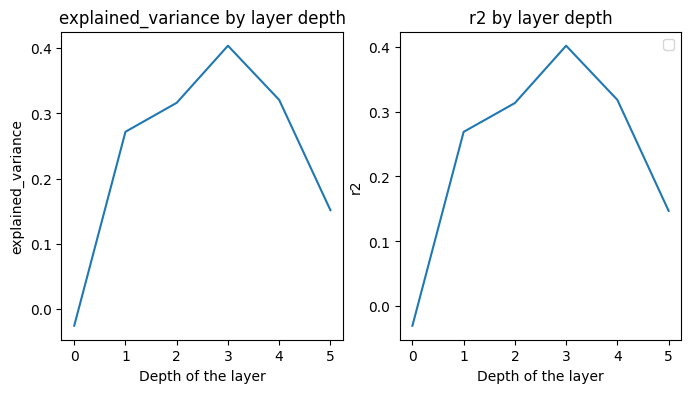

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
for ax, metric in zip(axs, ("explained_variance", "r2")):
    values = [scores[key][metric] for key in shapes.keys()]
    print(values)
    ax.plot(range(len(values)), values)
    ax.set_xlabel("Depth of the layer")
    ax.set_ylabel(metric)
    ax.set_title(f"{metric} by layer depth")
plt.legend()

**Observation:** Using ResNet activations to predict the neural spikes has a higher performance than our previous approach. Furthermore, there is an increase of performance with the depth up to ```layer 3``` which can be explained by the IT neurons been higher in the visual path.

In [55]:
scores = analyze("pretrained", "Ridge")

Layer conv1
Set name : train
RMSE: 0.31154726933988214
R2: 0.2787106846742685
Explained Variance: 0.2787106316754051
Set name : validation
RMSE: 0.3538165343476357
R2: 0.09433849204180308
Explained Variance: 0.09825084379183774



Layer layer1
Set name : train
RMSE: 0.26901072320247216
R2: 0.4449678917432025
Explained Variance: 0.444967853531572
Set name : validation
RMSE: 0.31806856129004585
R2: 0.24959653497491507
Explained Variance: 0.2529699682787583



Layer layer2
Set name : train
RMSE: 0.22219928579929596
R2: 0.6075975901998821
Explained Variance: 0.6075975634754424
Set name : validation
RMSE: 0.29797691162089573
R2: 0.32080893114569586
Explained Variance: 0.3239490463354767



Layer layer3
Set name : train
RMSE: 0.23178718711256868
R2: 0.5631064440490315
Explained Variance: 0.5631064151682537
Set name : validation
RMSE: 0.2794857369004714
R2: 0.3881980790548024
Explained Variance: 0.39103156517408794



Layer layer4
Set name : train
RMSE: 0.25718649889341993
R2: 0.4689491914572

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.09825084379183774, 0.2529699682787583, 0.3239490463354767, 0.39103156517408794, 0.3640022517042184, 0.309646705412525]
[0.09433849204180308, 0.24959653497491507, 0.32080893114569586, 0.3881980790548024, 0.3607124214436056, 0.306077613077833]


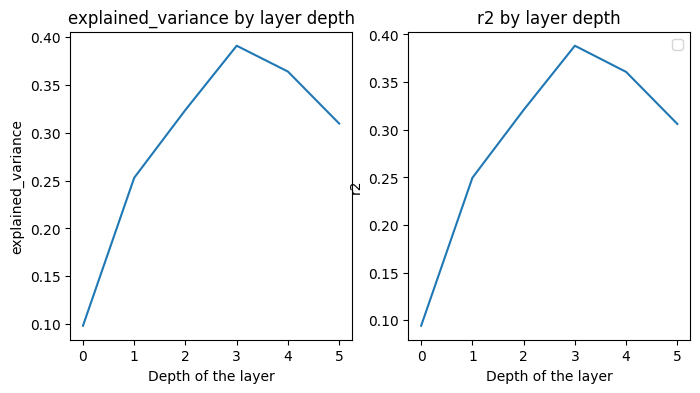

In [56]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
for ax, metric in zip(axs, ("explained_variance", "r2")):
    values = [scores[key][metric] for key in shapes.keys()]
    print(values)
    ax.plot(range(len(values)), values)
    ax.set_xlabel("Depth of the layer")
    ax.set_ylabel(metric)
    ax.set_title(f"{metric} by layer depth")
plt.legend()

## Analysis for randomly initialized network

In [62]:
scores = analyze("randomly_initialized", "Linear")

Layer conv1
Set name : train
RMSE: 0.2682241201400757
R2: 0.4633775466584278
Explained Variance: 0.463377578272706
Set name : validation
RMSE: 0.3840535581111908
R2: -0.0734732979094916
Explained Variance: -0.06927890295074099



Layer layer1
Set name : train
RMSE: 0.24127399921417236
R2: 0.5544134241873555
Explained Variance: 0.5544134421007973
Set name : validation
RMSE: 0.34035488963127136
R2: 0.12984746757703855
Explained Variance: 0.13463522458360308



Layer layer2
Set name : train
RMSE: 0.24067004024982452
R2: 0.556333295702976
Explained Variance: 0.5563333112569082
Set name : validation
RMSE: 0.3340419828891754
R2: 0.16267778806631913
Explained Variance: 0.1677444882336117



Layer layer3
Set name : train
RMSE: 0.24512885510921478
R2: 0.5420527898258433
Explained Variance: 0.5420527855555216
Set name : validation
RMSE: 0.3401193916797638
R2: 0.13273117240606172
Explained Variance: 0.13656897771926152



Layer layer4
Set name : train
RMSE: 0.24843725562095642
R2: 0.5296578063461

[-0.06927890295074099, 0.13463522458360308, 0.1677444882336117, 0.13656897771926152, 0.09813114149229867, -0.1549441676054682]
[-0.0734732979094916, 0.12984746757703855, 0.16267778806631913, 0.13273117240606172, 0.09513581790224751, -0.15862828877437102]


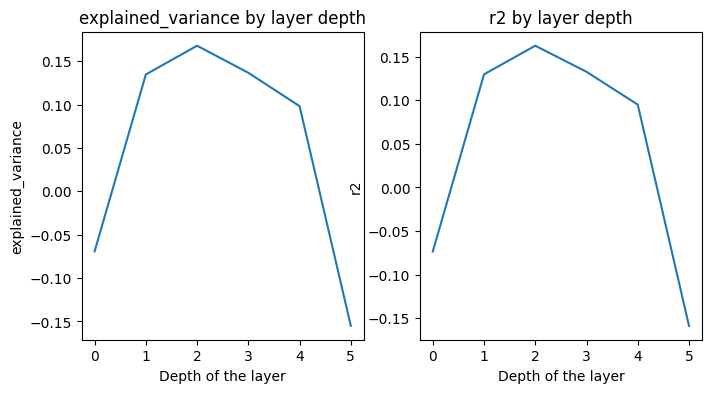

In [63]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
for ax, metric in zip(axs, ("explained_variance", "r2")):
    values = [scores[key][metric] for key in shapes.keys()]
    print(values)
    ax.plot(range(len(values)), values)
    ax.set_xlabel("Depth of the layer")
    ax.set_ylabel(metric)
    ax.set_title(f"{metric} by layer depth")

In [59]:
scores = analyze("randomly_initialized", "Ridge")

Layer conv1
Set name : train
RMSE: 0.3364187289533312
R2: 0.1593811744783355
Explained Variance: 0.1593811129843055
Set name : validation
RMSE: 0.35511286428158073
R2: 0.08868552854288268
Explained Variance: 0.09284115417255767



Layer layer1
Set name : train
RMSE: 0.2847159955861034
R2: 0.3858027480225207
Explained Variance: 0.3858027062997067
Set name : validation
RMSE: 0.3300933141625997
R2: 0.19260992035207142
Explained Variance: 0.19695396166455387



Layer layer2
Set name : train
RMSE: 0.2665226541777287
R2: 0.45928301878238526
Explained Variance: 0.45928298210874546
Set name : validation
RMSE: 0.32694313132813757
R2: 0.20437807761409635
Explained Variance: 0.20919690413292485



Layer layer3
Set name : train
RMSE: 0.31589237306081264
R2: 0.250269517309549
Explained Variance: 0.2502694661078802
Set name : validation
RMSE: 0.33990961374532785
R2: 0.15544954034064087
Explained Variance: 0.16000131725011496



Layer layer4
Set name : train
RMSE: 0.3059579913429177
R2: 0.29532025864

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.09284115417255767, 0.19695396166455387, 0.20919690413292485, 0.16000131725011496, 0.16302204702171116, 0.11074954068835906]
[0.08868552854288268, 0.19260992035207142, 0.20437807761409635, 0.15544954034064087, 0.15879363560937548, 0.10713836713200721]


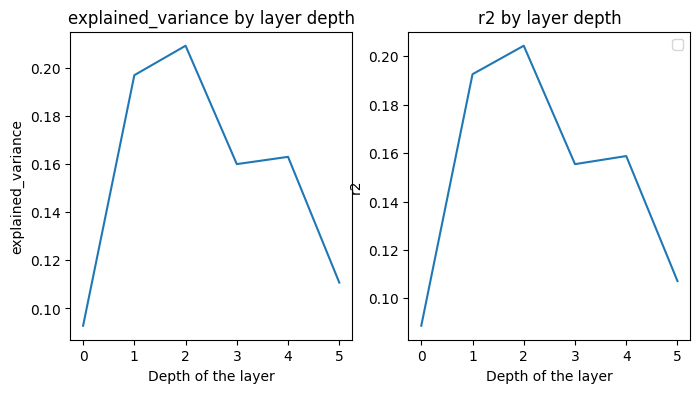

In [60]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
for ax, metric in zip(axs, ("explained_variance", "r2")):
    values = [scores[key][metric] for key in shapes.keys()]
    print(values)
    ax.plot(range(len(values)), values)
    ax.set_xlabel("Depth of the layer")
    ax.set_ylabel(metric)
    ax.set_title(f"{metric} by layer depth")
plt.legend()

**Observation:** Although using a randomly initialized network lead to a similar pattern in explained variance there is a decrease in the maximal explained variance as well as the depth of the layer leading to it. The best network to predict IT neurons is the pretrained ResNet which has the correct inductive bias (been a CNN) as well as having built a representation (gabor filters on the conv1 layer) by training on a large corpus.